In [2]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [3]:
set_config(transform_output="pandas")

### Load the data

In [ ]:
data = fetch_california_housing(as_frame=True)
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
# make X and y

X, y = data.data, data.target

In [6]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [9]:
X.shape

(20640, 8)

In [10]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


### Training model

In [11]:
# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

# fit the training data
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
# Calculate   s the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


### Hyperparameter tuning

In [13]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [14]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-11-30 23:46:00,585] A new study created in memory with name: no-name-bc7e895b-07f0-4567-9e8f-3bef723755c2
Best trial: 8. Best value: 0.784934:   2%|▏         | 1/50 [00:01<00:57,  1.17s/it]

[I 2025-11-30 23:46:01,715] Trial 8 finished with value: 0.7849341798153571 and parameters: {'learning_rate': 0.14632835757205706, 'n_estimators': 81, 'max_depth': 3, 'reg_lambda': 40.08228391808589, 'gamma': 0.16188344302145063, 'subsample': 0.972611995408178}. Best is trial 8 with value: 0.7849341798153571.


Best trial: 9. Best value: 0.81651:   4%|▍         | 2/50 [00:01<00:44,  1.07it/s] 

[I 2025-11-30 23:46:02,488] Trial 9 finished with value: 0.8165098252833034 and parameters: {'learning_rate': 0.1897920646452772, 'n_estimators': 190, 'max_depth': 6, 'reg_lambda': 4.486749613873577, 'gamma': 1.930519072576839, 'subsample': 0.7381440959525083}. Best is trial 9 with value: 0.8165098252833034.


Best trial: 15. Best value: 0.822507:   6%|▌         | 3/50 [00:02<00:34,  1.37it/s]

[I 2025-11-30 23:46:02,984] Trial 15 finished with value: 0.8225069875692622 and parameters: {'learning_rate': 0.20502531136417299, 'n_estimators': 193, 'max_depth': 7, 'reg_lambda': 53.293892669082055, 'gamma': 1.4135525558677007, 'subsample': 0.8093894389777215}. Best is trial 15 with value: 0.8225069875692622.
[I 2025-11-30 23:46:03,034] Trial 0 finished with value: 0.7909430368729049 and parameters: {'learning_rate': 0.079607092385424, 'n_estimators': 175, 'max_depth': 3, 'reg_lambda': 2.9165105277494265, 'gamma': 1.4139253888217977, 'subsample': 0.7034505927421469}. Best is trial 15 with value: 0.8225069875692622.


Best trial: 2. Best value: 0.832443:  12%|█▏        | 6/50 [00:02<00:14,  3.00it/s] 

[I 2025-11-30 23:46:03,345] Trial 1 finished with value: 0.8188569114790822 and parameters: {'learning_rate': 0.2705536987442272, 'n_estimators': 349, 'max_depth': 7, 'reg_lambda': 38.54172933487694, 'gamma': 1.0269879447215176, 'subsample': 0.9976712701104795}. Best is trial 15 with value: 0.8225069875692622.
[I 2025-11-30 23:46:03,468] Trial 2 finished with value: 0.8324425219330971 and parameters: {'learning_rate': 0.265066513849614, 'n_estimators': 171, 'max_depth': 4, 'reg_lambda': 23.69025389182644, 'gamma': 0.4946361918893425, 'subsample': 0.8464213118480828}. Best is trial 2 with value: 0.8324425219330971.


Best trial: 2. Best value: 0.832443:  12%|█▏        | 6/50 [00:03<00:14,  3.00it/s]

[I 2025-11-30 23:46:03,553] Trial 11 finished with value: 0.6530350024080043 and parameters: {'learning_rate': 0.018585429748374474, 'n_estimators': 69, 'max_depth': 10, 'reg_lambda': 58.245138427079766, 'gamma': 1.4029259735424695, 'subsample': 0.7571582384426141}. Best is trial 2 with value: 0.8324425219330971.


Best trial: 2. Best value: 0.832443:  18%|█▊        | 9/50 [00:03<00:12,  3.30it/s]

[I 2025-11-30 23:46:04,272] Trial 12 finished with value: 0.8294913159579399 and parameters: {'learning_rate': 0.2582784214446718, 'n_estimators': 283, 'max_depth': 10, 'reg_lambda': 29.903587460246207, 'gamma': 0.8687695109426412, 'subsample': 0.7144838913416055}. Best is trial 2 with value: 0.8324425219330971.
[I 2025-11-30 23:46:04,387] Trial 14 finished with value: 0.8273967333831387 and parameters: {'learning_rate': 0.27205680630932405, 'n_estimators': 290, 'max_depth': 3, 'reg_lambda': 11.090288401099889, 'gamma': 0.6090160752642324, 'subsample': 0.8537128713909403}. Best is trial 2 with value: 0.8324425219330971.


Best trial: 2. Best value: 0.832443:  20%|██        | 10/50 [00:04<00:10,  3.90it/s]

[I 2025-11-30 23:46:04,492] Trial 3 finished with value: 0.8203538304045634 and parameters: {'learning_rate': 0.2679895685896622, 'n_estimators': 410, 'max_depth': 3, 'reg_lambda': 87.32601606383714, 'gamma': 0.999823277762931, 'subsample': 0.7764671199322773}. Best is trial 2 with value: 0.8324425219330971.
[I 2025-11-30 23:46:04,575] Trial 10 finished with value: 0.8131807629687544 and parameters: {'learning_rate': 0.05494155646669363, 'n_estimators': 114, 'max_depth': 9, 'reg_lambda': 97.04714079074591, 'gamma': 1.9936052790126557, 'subsample': 0.7501883827994831}. Best is trial 2 with value: 0.8324425219330971.


Best trial: 2. Best value: 0.832443:  24%|██▍       | 12/50 [00:04<00:07,  4.94it/s]

[I 2025-11-30 23:46:04,820] Trial 16 finished with value: 0.8213611613687825 and parameters: {'learning_rate': 0.17563105577431556, 'n_estimators': 326, 'max_depth': 10, 'reg_lambda': 26.447520342511783, 'gamma': 1.6411658737649166, 'subsample': 0.9539013903878172}. Best is trial 2 with value: 0.8324425219330971.


Best trial: 6. Best value: 0.835697:  26%|██▌       | 13/50 [00:04<00:07,  5.03it/s]

[I 2025-11-30 23:46:04,992] Trial 5 finished with value: 0.8327819640321358 and parameters: {'learning_rate': 0.22854033352205858, 'n_estimators': 332, 'max_depth': 4, 'reg_lambda': 6.203250068307441, 'gamma': 0.4995027109897743, 'subsample': 0.8106873824237201}. Best is trial 5 with value: 0.8327819640321358.
[I 2025-11-30 23:46:05,077] Trial 6 finished with value: 0.8356969322594842 and parameters: {'learning_rate': 0.22259799597270172, 'n_estimators': 382, 'max_depth': 8, 'reg_lambda': 35.766941058396675, 'gamma': 0.8623098522263783, 'subsample': 0.7507568446164172}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 6. Best value: 0.835697:  30%|███       | 15/50 [00:04<00:05,  6.45it/s]

[I 2025-11-30 23:46:05,183] Trial 13 finished with value: 0.8034125447162794 and parameters: {'learning_rate': 0.10518960744243182, 'n_estimators': 462, 'max_depth': 4, 'reg_lambda': 64.15830105019, 'gamma': 1.6831118455187106, 'subsample': 0.9638994715950109}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 6. Best value: 0.835697:  32%|███▏      | 16/50 [00:04<00:06,  5.38it/s]

[I 2025-11-30 23:46:05,465] Trial 7 finished with value: 0.817113843672082 and parameters: {'learning_rate': 0.05801788641172395, 'n_estimators': 195, 'max_depth': 8, 'reg_lambda': 99.51061826106304, 'gamma': 1.787787488002797, 'subsample': 0.7255452276602005}. Best is trial 6 with value: 0.8356969322594842.
[I 2025-11-30 23:46:05,556] Trial 18 finished with value: 0.8193451849064124 and parameters: {'learning_rate': 0.20295398176137747, 'n_estimators': 161, 'max_depth': 8, 'reg_lambda': 47.78602647279739, 'gamma': 1.2645643292795783, 'subsample': 0.9279007478823962}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 6. Best value: 0.835697:  36%|███▌      | 18/50 [00:05<00:07,  4.27it/s]

[I 2025-11-30 23:46:06,100] Trial 20 finished with value: 0.8243195726922011 and parameters: {'learning_rate': 0.08726114474473035, 'n_estimators': 57, 'max_depth': 10, 'reg_lambda': 33.84549588460433, 'gamma': 0.49561149947433636, 'subsample': 0.7719313005091176}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 6. Best value: 0.835697:  38%|███▊      | 19/50 [00:05<00:07,  4.30it/s]

[I 2025-11-30 23:46:06,325] Trial 23 finished with value: 0.7695421795602896 and parameters: {'learning_rate': 0.055317673598891136, 'n_estimators': 99, 'max_depth': 4, 'reg_lambda': 53.00418475398816, 'gamma': 0.191523639382426, 'subsample': 0.7571008312547445}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 6. Best value: 0.835697:  40%|████      | 20/50 [00:06<00:10,  2.91it/s]

[I 2025-11-30 23:46:07,013] Trial 19 finished with value: 0.817678497859845 and parameters: {'learning_rate': 0.1967761416188015, 'n_estimators': 392, 'max_depth': 4, 'reg_lambda': 18.747351041787464, 'gamma': 1.469626735833691, 'subsample': 0.8074281353677148}. Best is trial 6 with value: 0.8356969322594842.


Best trial: 4. Best value: 0.846531:  44%|████▍     | 22/50 [00:06<00:08,  3.37it/s]

[I 2025-11-30 23:46:07,368] Trial 25 finished with value: 0.8250020358281516 and parameters: {'learning_rate': 0.1267625108820201, 'n_estimators': 134, 'max_depth': 5, 'reg_lambda': 76.77100158091721, 'gamma': 0.010996456698410206, 'subsample': 0.8862234584283275}. Best is trial 6 with value: 0.8356969322594842.
[I 2025-11-30 23:46:07,516] Trial 4 finished with value: 0.8465305426996951 and parameters: {'learning_rate': 0.10314110217554424, 'n_estimators': 244, 'max_depth': 7, 'reg_lambda': 68.7576737503417, 'gamma': 0.044111741610971755, 'subsample': 0.7403923791773916}. Best is trial 4 with value: 0.8465305426996951.


Best trial: 4. Best value: 0.846531:  44%|████▍     | 22/50 [00:07<00:08,  3.37it/s]

[I 2025-11-30 23:46:07,603] Trial 21 finished with value: 0.8220217903278147 and parameters: {'learning_rate': 0.11692705318605788, 'n_estimators': 304, 'max_depth': 6, 'reg_lambda': 88.98946056697984, 'gamma': 1.1882758894549221, 'subsample': 0.9220028608960621}. Best is trial 4 with value: 0.8465305426996951.


Best trial: 4. Best value: 0.846531:  48%|████▊     | 24/50 [00:07<00:07,  3.35it/s]

[I 2025-11-30 23:46:08,132] Trial 24 finished with value: 0.8360230037402827 and parameters: {'learning_rate': 0.13908305855657369, 'n_estimators': 109, 'max_depth': 8, 'reg_lambda': 87.08839499247433, 'gamma': 0.53011336850655, 'subsample': 0.7887953988496897}. Best is trial 4 with value: 0.8465305426996951.


Best trial: 4. Best value: 0.846531:  50%|█████     | 25/50 [00:08<00:08,  2.94it/s]

[I 2025-11-30 23:46:08,602] Trial 26 finished with value: 0.8419392065174627 and parameters: {'learning_rate': 0.21318025031589713, 'n_estimators': 272, 'max_depth': 5, 'reg_lambda': 23.36336575587812, 'gamma': 0.3572121869791751, 'subsample': 0.8882891188900488}. Best is trial 4 with value: 0.8465305426996951.


Best trial: 4. Best value: 0.846531:  54%|█████▍    | 27/50 [00:09<00:10,  2.28it/s]

[I 2025-11-30 23:46:09,790] Trial 22 finished with value: 0.8431326689619274 and parameters: {'learning_rate': 0.13340207686797723, 'n_estimators': 241, 'max_depth': 6, 'reg_lambda': 2.2532026913146135, 'gamma': 0.0008143654000842826, 'subsample': 0.9933884179188135}. Best is trial 4 with value: 0.8465305426996951.
[I 2025-11-30 23:46:09,911] Trial 34 finished with value: 0.8335251962996878 and parameters: {'learning_rate': 0.23358254634722017, 'n_estimators': 398, 'max_depth': 6, 'reg_lambda': 15.537382085809728, 'gamma': 0.720385420517462, 'subsample': 0.8116398256196935}. Best is trial 4 with value: 0.8465305426996951.


Best trial: 17. Best value: 0.846602:  56%|█████▌    | 28/50 [00:09<00:07,  2.82it/s]

[I 2025-11-30 23:46:10,044] Trial 17 finished with value: 0.8466024499791189 and parameters: {'learning_rate': 0.12396387178644677, 'n_estimators': 390, 'max_depth': 5, 'reg_lambda': 20.419249853784827, 'gamma': 0.22815863271972514, 'subsample': 0.7959771841951999}. Best is trial 17 with value: 0.8466024499791189.
[I 2025-11-30 23:46:10,108] Trial 27 finished with value: 0.8431997703019491 and parameters: {'learning_rate': 0.2328186518121171, 'n_estimators': 491, 'max_depth': 5, 'reg_lambda': 25.33121906059519, 'gamma': 0.4073454225024486, 'subsample': 0.8625434672376953}. Best is trial 17 with value: 0.8466024499791189.


Best trial: 17. Best value: 0.846602:  60%|██████    | 30/50 [00:09<00:06,  3.21it/s]

[I 2025-11-30 23:46:10,558] Trial 37 finished with value: 0.8363047552391882 and parameters: {'learning_rate': 0.22045695632915155, 'n_estimators': 249, 'max_depth': 6, 'reg_lambda': 69.48326397104437, 'gamma': 0.6876933511633987, 'subsample': 0.7980429935226357}. Best is trial 17 with value: 0.8466024499791189.


Best trial: 28. Best value: 0.848342:  62%|██████▏   | 31/50 [00:10<00:05,  3.33it/s]

[I 2025-11-30 23:46:10,824] Trial 38 finished with value: 0.8359920980039692 and parameters: {'learning_rate': 0.23182124691640685, 'n_estimators': 250, 'max_depth': 8, 'reg_lambda': 66.12146153841671, 'gamma': 0.7257971442370302, 'subsample': 0.7973732396815664}. Best is trial 17 with value: 0.8466024499791189.
[I 2025-11-30 23:46:10,878] Trial 28 finished with value: 0.8483420576521714 and parameters: {'learning_rate': 0.2297287011515099, 'n_estimators': 469, 'max_depth': 5, 'reg_lambda': 19.028540896310712, 'gamma': 0.24446324178728968, 'subsample': 0.8867998442826858}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  66%|██████▌   | 33/50 [00:10<00:05,  3.18it/s]

[I 2025-11-30 23:46:11,493] Trial 35 finished with value: 0.8351551340175775 and parameters: {'learning_rate': 0.2361340076802377, 'n_estimators': 500, 'max_depth': 6, 'reg_lambda': 74.7875863276746, 'gamma': 0.7040144429279296, 'subsample': 0.8871081296572121}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  68%|██████▊   | 34/50 [00:11<00:05,  3.17it/s]

[I 2025-11-30 23:46:11,815] Trial 30 finished with value: 0.8474256832589702 and parameters: {'learning_rate': 0.21998698025254376, 'n_estimators': 394, 'max_depth': 8, 'reg_lambda': 71.63574428615237, 'gamma': 0.1712215775777891, 'subsample': 0.9043053783705195}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  70%|███████   | 35/50 [00:11<00:04,  3.41it/s]

[I 2025-11-30 23:46:12,039] Trial 36 finished with value: 0.836908056353366 and parameters: {'learning_rate': 0.22787112322589834, 'n_estimators': 484, 'max_depth': 5, 'reg_lambda': 17.442638404426045, 'gamma': 0.5527530566815565, 'subsample': 0.8234592662895932}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  72%|███████▏  | 36/50 [00:11<00:04,  3.07it/s]

[I 2025-11-30 23:46:12,455] Trial 39 finished with value: 0.8389354631610906 and parameters: {'learning_rate': 0.1524984509933693, 'n_estimators': 253, 'max_depth': 8, 'reg_lambda': 74.3132377121663, 'gamma': 0.6968797130025601, 'subsample': 0.7850426900586157}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  76%|███████▌  | 38/50 [00:12<00:03,  3.29it/s]

[I 2025-11-30 23:46:12,965] Trial 31 finished with value: 0.8470531704962491 and parameters: {'learning_rate': 0.2231187737214272, 'n_estimators': 412, 'max_depth': 5, 'reg_lambda': 15.644597483358151, 'gamma': 0.08616690470435262, 'subsample': 0.8048410543040563}. Best is trial 28 with value: 0.8483420576521714.
[I 2025-11-30 23:46:13,084] Trial 40 finished with value: 0.8428145755791852 and parameters: {'learning_rate': 0.15566507535521185, 'n_estimators': 236, 'max_depth': 6, 'reg_lambda': 73.04124286003014, 'gamma': 0.29936279607259075, 'subsample': 0.863952868067282}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  76%|███████▌  | 38/50 [00:12<00:03,  3.29it/s]

[I 2025-11-30 23:46:13,159] Trial 32 finished with value: 0.8481719868480848 and parameters: {'learning_rate': 0.23311250252499102, 'n_estimators': 398, 'max_depth': 5, 'reg_lambda': 76.19949139561751, 'gamma': 0.08119418665178979, 'subsample': 0.8008719593377611}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 28. Best value: 0.848342:  80%|████████  | 40/50 [00:13<00:03,  3.30it/s]

[I 2025-11-30 23:46:13,680] Trial 33 finished with value: 0.8476112313463693 and parameters: {'learning_rate': 0.22264294856006156, 'n_estimators': 394, 'max_depth': 5, 'reg_lambda': 17.559736103417617, 'gamma': 0.02111094023712512, 'subsample': 0.8118899681655979}. Best is trial 28 with value: 0.8483420576521714.


Best trial: 29. Best value: 0.855325:  84%|████████▍ | 42/50 [00:13<00:01,  4.15it/s]

[I 2025-11-30 23:46:13,885] Trial 29 finished with value: 0.8553249901916125 and parameters: {'learning_rate': 0.22270113453824245, 'n_estimators': 497, 'max_depth': 5, 'reg_lambda': 63.35227934965973, 'gamma': 0.1016777636285155, 'subsample': 0.88134720457696}. Best is trial 29 with value: 0.8553249901916125.
[I 2025-11-30 23:46:14,018] Trial 41 finished with value: 0.8425015925343154 and parameters: {'learning_rate': 0.16989612444505514, 'n_estimators': 244, 'max_depth': 5, 'reg_lambda': 14.325515863710102, 'gamma': 0.30581700250001465, 'subsample': 0.886987657389575}. Best is trial 29 with value: 0.8553249901916125.


Best trial: 29. Best value: 0.855325:  84%|████████▍ | 42/50 [00:13<00:01,  4.15it/s]

[I 2025-11-30 23:46:14,087] Trial 42 finished with value: 0.8426233797161536 and parameters: {'learning_rate': 0.16327530452156427, 'n_estimators': 237, 'max_depth': 5, 'reg_lambda': 64.33574496185004, 'gamma': 0.27031785332751446, 'subsample': 0.8839855585216319}. Best is trial 29 with value: 0.8553249901916125.


Best trial: 29. Best value: 0.855325:  88%|████████▊ | 44/50 [00:13<00:01,  4.97it/s]

[I 2025-11-30 23:46:14,314] Trial 43 finished with value: 0.8334490966353982 and parameters: {'learning_rate': 0.09864886076516322, 'n_estimators': 246, 'max_depth': 5, 'reg_lambda': 75.2122586306257, 'gamma': 0.23966008557256727, 'subsample': 0.8769661231364254}. Best is trial 29 with value: 0.8553249901916125.


Best trial: 29. Best value: 0.855325:  94%|█████████▍| 47/50 [00:14<00:00,  4.02it/s]

[I 2025-11-30 23:46:15,261] Trial 48 finished with value: 0.8440308987262812 and parameters: {'learning_rate': 0.2949206873511181, 'n_estimators': 445, 'max_depth': 5, 'reg_lambda': 44.64124536883082, 'gamma': 0.3245250711271247, 'subsample': 0.8497962086063329}. Best is trial 29 with value: 0.8553249901916125.
[I 2025-11-30 23:46:15,275] Trial 45 finished with value: 0.8475204182307212 and parameters: {'learning_rate': 0.2950420448045636, 'n_estimators': 489, 'max_depth': 5, 'reg_lambda': 74.83995265722653, 'gamma': 0.2628137027094896, 'subsample': 0.8374973628917628}. Best is trial 29 with value: 0.8553249901916125.
[I 2025-11-30 23:46:15,382] Trial 44 finished with value: 0.8469733343004654 and parameters: {'learning_rate': 0.16311956430334823, 'n_estimators': 478, 'max_depth': 5, 'reg_lambda': 43.21971513318563, 'gamma': 0.28784277491881827, 'subsample': 0.8391142534858085}. Best is trial 29 with value: 0.8553249901916125.


Best trial: 29. Best value: 0.855325:  96%|█████████▌| 48/50 [00:14<00:00,  4.35it/s]

[I 2025-11-30 23:46:15,548] Trial 47 finished with value: 0.8466027520928199 and parameters: {'learning_rate': 0.16116862270650636, 'n_estimators': 496, 'max_depth': 5, 'reg_lambda': 43.54739487964994, 'gamma': 0.3116879012053667, 'subsample': 0.8428859358834254}. Best is trial 29 with value: 0.8553249901916125.


Best trial: 29. Best value: 0.855325: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]

[I 2025-11-30 23:46:15,919] Trial 49 finished with value: 0.8483398054196636 and parameters: {'learning_rate': 0.17135360169365732, 'n_estimators': 425, 'max_depth': 7, 'reg_lambda': 79.45449829464167, 'gamma': 0.23605026140312305, 'subsample': 0.8368119637569768}. Best is trial 29 with value: 0.8553249901916125.
[I 2025-11-30 23:46:16,013] Trial 46 finished with value: 0.8439686220549011 and parameters: {'learning_rate': 0.29588515401733156, 'n_estimators': 472, 'max_depth': 5, 'reg_lambda': 10.567043287167845, 'gamma': 0.05106313462557872, 'subsample': 0.8388327647711351}. Best is trial 29 with value: 0.8553249901916125.


In [15]:
# get the best parameters
study.best_params

{'learning_rate': 0.22270113453824245,
 'n_estimators': 497,
 'max_depth': 5,
 'reg_lambda': 63.35227934965973,
 'gamma': 0.1016777636285155,
 'subsample': 0.88134720457696}

In [16]:
# get the best value
study.best_value

0.8553249901916125

In [17]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2861, R2: 0.9388
Test RMSE: 0.4390, R2: 0.8529


### Apply SHAP to explain values

In [19]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [21]:
# expected value
explainer.expected_value

np.float64(2.004642575925875)

In [22]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4091/4128 [01:03<00:00]        

In [23]:
print("Shap values shape", shap_values.shape)
print("Length of features", len(feature_names))
print("Feature name", feature_names)

Shap values shape (4128, 8)
Length of features 8
Feature name ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [24]:
shap_values[0:5]

.values =
array([[-2.81136011e-01,  1.03017038e-02, -1.34621221e-01,
         1.93303112e-02, -2.48071040e-02, -2.12096626e-01,
        -8.08389086e-01, -3.14479512e-02],
       [-2.70346842e-01,  2.35904563e-02, -1.05262759e-01,
         4.02601859e-02,  2.04335950e-02, -7.75652654e-02,
        -7.99850161e-01,  9.55224382e-02],
       [ 1.36260511e-01,  3.45455149e-01, -5.87397232e-02,
         3.09633190e-02, -4.72695373e-02,  7.16147666e-01,
         3.78007341e-03,  1.99633505e+00],
       [ 4.60745530e-01,  3.47230542e-02,  2.11534504e-01,
        -4.23953474e-04, -4.00080009e-03, -3.17495696e-01,
         7.66188237e-02,  6.68155514e-02],
       [-2.51517573e-02,  4.63129989e-03,  3.99713772e-03,
         1.34588120e-02, -8.22168168e-03,  2.23294937e-02,
        -5.99444553e-01,  1.10081115e+00]])

.base_values =
array([2.00464258, 2.00464258, 2.00464258, 2.00464258, 2.00464258])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.3920

In [25]:
X_test.head(1).values

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02]])

## Global Plots

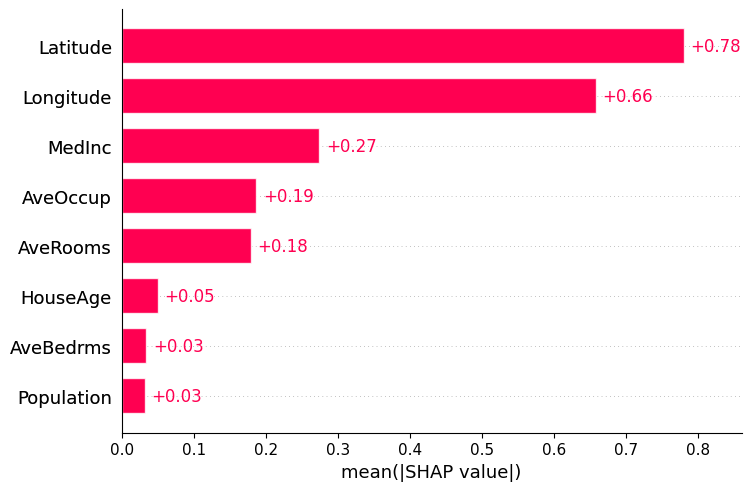

In [26]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [27]:
shap_values.abs.mean(axis=0)

.values =
array([0.27415264, 0.04995482, 0.17931093, 0.03447462, 0.03202328,
       0.18664216, 0.7800536 , 0.65813945])

.base_values =
np.float64(2.004642575925875)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [28]:
shap_values.abs.mean(axis=0).values

array([0.27415264, 0.04995482, 0.17931093, 0.03447462, 0.03202328,
       0.18664216, 0.7800536 , 0.65813945])

In [29]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.2741526444527906),
 'HouseAge': np.float64(0.04995482220413208),
 'AveRooms': np.float64(0.179310928957931),
 'AveBedrms': np.float64(0.034474615796318844),
 'Population': np.float64(0.032023284541710426),
 'AveOccup': np.float64(0.18664215570075607),
 'Latitude': np.float64(0.7800535990666384),
 'Longitude': np.float64(0.6581394492726387)}

In [31]:
feature_importances = {feature:shap_val.item() for feature, shap_val in 
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

feature_importances

{'MedInc': 0.2741526444527906,
 'HouseAge': 0.04995482220413208,
 'AveRooms': 0.179310928957931,
 'AveBedrms': 0.034474615796318844,
 'Population': 0.032023284541710426,
 'AveOccup': 0.18664215570075607,
 'Latitude': 0.7800535990666384,
 'Longitude': 0.6581394492726387}

In [32]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'AveBedrms',
 'Population']

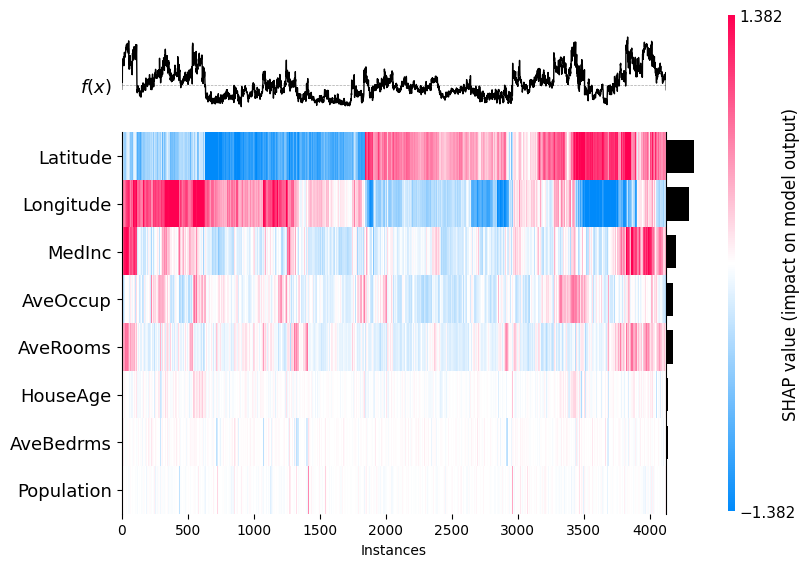

<Axes: xlabel='Instances'>

In [33]:
# heatmap plot

shap.plots.heatmap(shap_values)

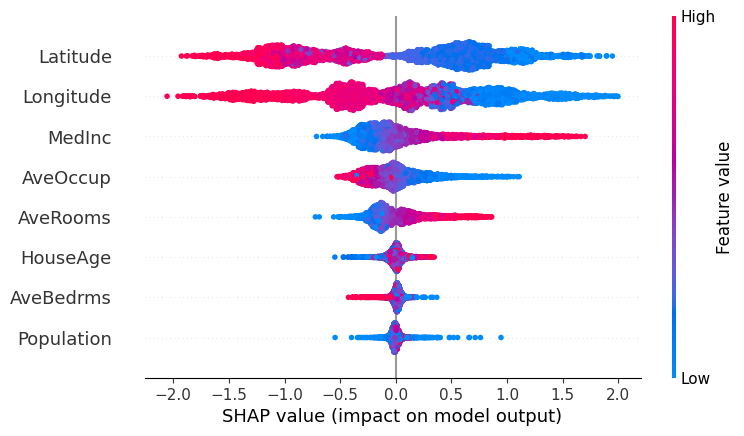

In [34]:
# summary plot

shap.plots.beeswarm(shap_values)

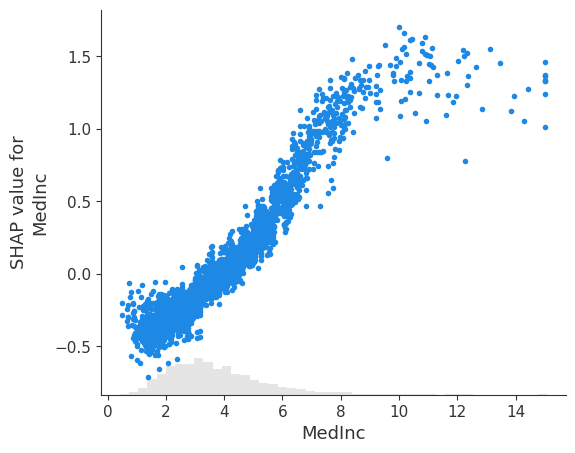

In [35]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

In [36]:
shap_values[:, "Latitude"]

.values =
array([-0.80838909, -0.79985016,  0.00378007, ..., -0.23694275,
       -1.11805044,  0.22894869], shape=(4128,))

.base_values =
array([2.00464258, 2.00464258, 2.00464258, ..., 2.00464258, 2.00464258,
       2.00464258], shape=(4128,))

.data =
array([36.06, 35.14, 37.8 , ..., 37.31, 36.77, 34.22], shape=(4128,))

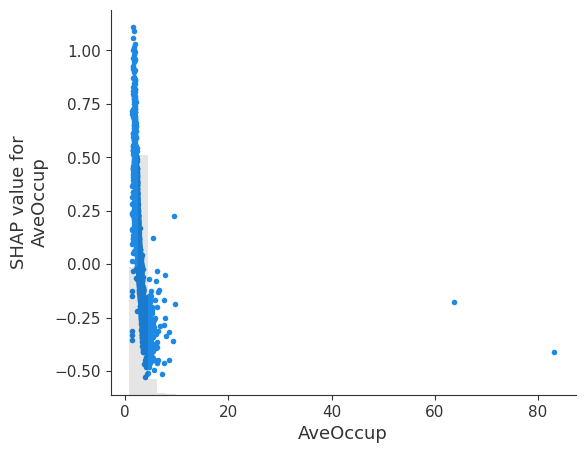

In [37]:
shap.plots.scatter(shap_values[:, "AveOccup"])

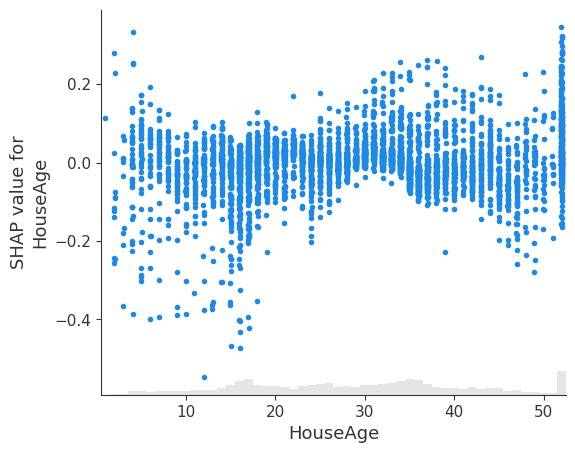

In [38]:
shap.plots.scatter(shap_values[:, "HouseAge"])

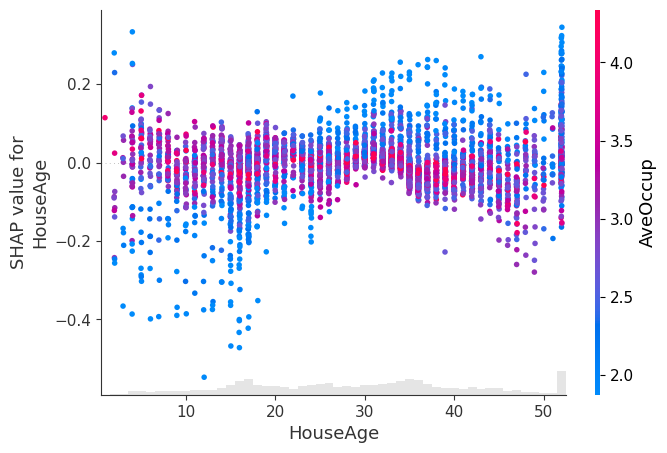

In [39]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

## Local Plots

In [40]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
13084,5.6485,26.0,7.629787,1.038298,653.0,2.778723,38.57,-121.36


In [41]:
explained_row = explainer(test_case)

explained_row

.values =
array([[ 0.41514706, -0.04311643,  0.62688504, -0.01683747,  0.07861902,
        -0.07083391, -1.19696599,  0.51048237]])

.base_values =
array([2.00464258])

.data =
array([[   5.6485    ,   26.        ,    7.62978723,    1.03829787,
         653.        ,    2.7787234 ,   38.57      , -121.36      ]])

In [42]:
explained_row[0,:].shape

(8,)

In [43]:
explained_row.shape

(1, 8)

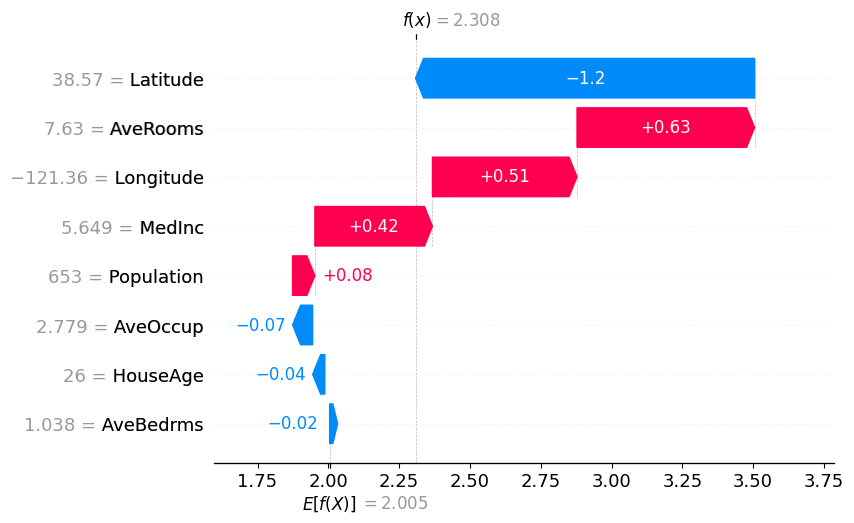

In [44]:
# waterfall plot

shap.plots.waterfall(explained_row[0])

In [45]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

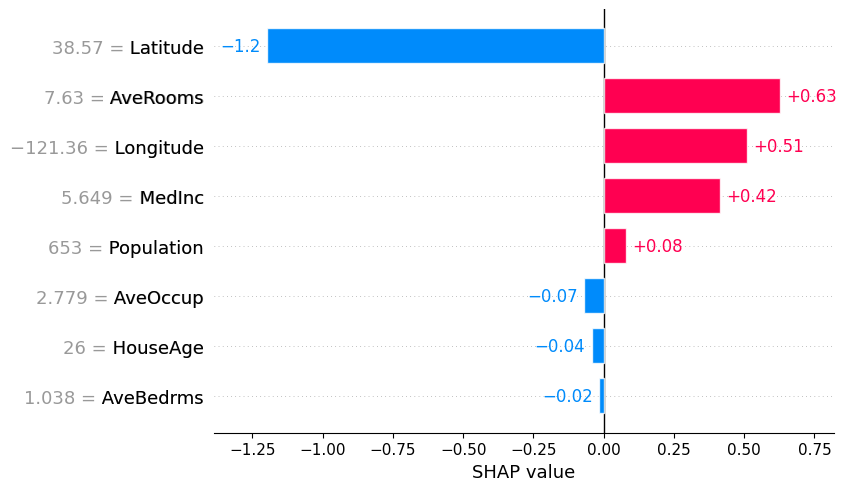

In [46]:
# bar plot for local explaination

shap.plots.bar(explained_row[0])

## LIME

In [47]:
# test case

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
13084,5.6485,26.0,7.629787,1.038298,653.0,2.778723,38.57,-121.36


In [48]:
# convert test case to a 1D array

test_case_lime = test_case.values.flatten()

In [50]:
from lime.lime_tabular import LimeTabularExplainer

In [51]:
X_train.values.shape

(16512, 8)

In [52]:
# feature names

feature_names = X_train.columns.tolist()

In [53]:
# make an lime explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="regression",
    feature_names=feature_names
)

In [54]:
# get the lime explanations

lime_explanation = lime_explainer.explain_instance(
    data_row=test_case_lime,
    predict_fn=xgb_model.predict
)

In [55]:
# lime explanations --> list of values

lime_explanation.as_list()

[('Latitude > 37.72', -1.1270988759298368),
 ('MedInc > 4.77', 0.9774580120850599),
 ('AveRooms > 6.06', 0.4764965671921432),
 ('-121.81 < Longitude <= -118.51', 0.2421723139285191),
 ('2.43 < AveOccup <= 2.82', 0.0354003153650341),
 ('18.00 < HouseAge <= 29.00', 0.026944626946009406),
 ('1.01 < AveBedrms <= 1.05', 0.022525493672991486),
 ('Population <= 789.00', -0.016599471615719067)]

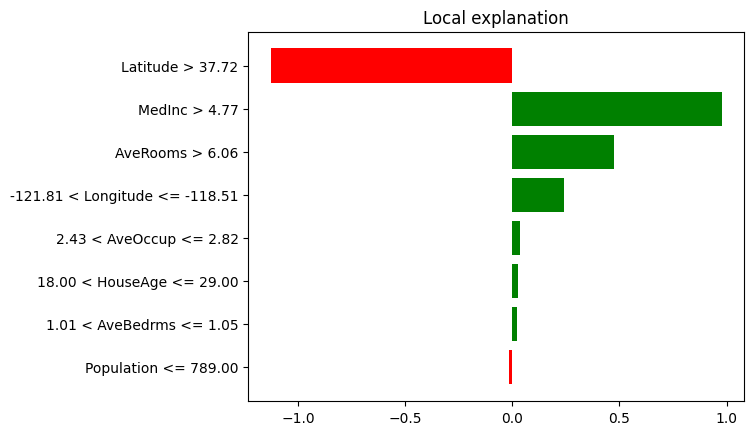

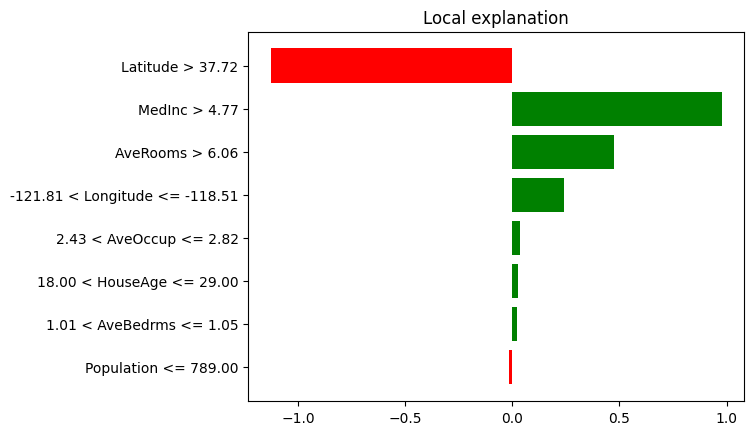

In [56]:
# lime explanations --> pyplot figure

lime_explanation.as_pyplot_figure()

In [57]:
# lime explanations --> as html

from IPython.core.display import HTML

In [58]:
xgb_model.predict(test_case)

array([2.2952619], dtype=float32)

In [59]:
# display explanation

display(HTML(lime_explanation.as_html()))